# Requirement 5

In [25]:
import numpy as np


class PricingEnvConversion:
    def __init__(self, intervals, B, T, n_customers=100):
        """
        intervals: list of dicts, each defining an interval with:
            - 'start': starting round index (inclusive)
            - 'end': ending round index (exclusive)
            - 'mu': N x P profit matrix for that interval
            - 'conversion_fn': function mapping price_idx -> buy prob
        B: total cumulative inventory across all rounds
        T: total number of rounds
        n_customers: number of potential buyers per round
        """
        self.intervals = intervals
        self.T = T
        self.n_customers = n_customers
        self.t = 0
        self.N, self.P = intervals[0]['mu'].shape
        self._set_interval(0)

    def _set_interval(self, idx):
        """Set mu and conversion function for the current interval"""
        self.current_interval = idx
        self.mu = self.intervals[idx]['mu']
        self.conversion_fn = self.intervals[idx]['conversion_fn']

    def round(self, price_vector):
        """
        Arguments:
            price_vector: list of chosen price indices per product (-1 = do not sell)
        Returns:
            demand: units sold per product
            profit: reward per product
        """
        if self.t >= self.T:
            raise Exception("Environment finished all rounds.")

        # Check if interval should change
        if self.current_interval < len(self.intervals) - 1:
            if self.t >= self.intervals[self.current_interval]['end']:
                self._set_interval(self.current_interval + 1)

        rewards_per_unit = np.zeros(self.N)
        demand = np.zeros(self.N, dtype=int)
        profit = np.zeros(self.N)

        for i in range(self.N):
            price_idx = price_vector[i]
            if price_idx == -1:
                # skip this product
                continue
            # compute reward and demand
            rewards_per_unit[i] = self.mu[i, price_idx]
            prob = self.conversion_fn(price_idx)
            demand[i] = np.random.binomial(self.n_customers, prob)
            profit[i] = rewards_per_unit[i] * demand[i]

        self.t += 1
        return demand, profit

In [26]:
from collections import deque
import numpy as np
from scipy import optimize

class CombinatorialUCB:
    def __init__(self, N, P, B, T, window_size=100):
        """
        N: number of products
        P: number of prices
        B: shared capacity (total inventory)
        T: total number of rounds
        window_size: number of past rounds to keep in the sliding window
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.window_size = window_size
        self.reset()

    def reset(self):
        """Reset agent state for a new simulation"""
        self.remaining_inventory = self.B
        self.t = 0
        # Sliding window: store last window_size rounds
        self.rewards_window = deque(maxlen=self.window_size)       
        self.consumptions_window = deque(maxlen=self.window_size)  

    def pull_arm(self):
        if self.remaining_inventory < 1:
            return [-1] * self.N

        # Compute empirical means and average consumptions from sliding window
        if len(self.rewards_window) == 0:
            means = np.zeros((self.N, self.P))
            avg_c = np.zeros((self.N, self.P))
            counts = np.zeros((self.N, self.P))
        else:
            rewards_stack = np.stack(self.rewards_window, axis=0)       # shape: window_size x N x P
            consumptions_stack = np.stack(self.consumptions_window, axis=0)
            counts = np.sum(rewards_stack != 0, axis=0)
            means = np.sum(rewards_stack, axis=0) / np.maximum(1, counts)
            avg_c = np.sum(consumptions_stack, axis=0) / np.maximum(1, counts)

        # Initial exploration
        if self.t < self.P:
            return [self.t % self.P for _ in range(self.N)]

        f_ucbs = means + np.sqrt(2*np.log(self.t) / (counts + 1e-6))
        c_lcbs = avg_c - np.sqrt(2*np.log(self.t) / (counts + 1e-6))

        rho = self.remaining_inventory / max(1, self.T - self.t)

        # solve LP to compute probabilities over prices
        gamma = self.compute_opt(f_ucbs, c_lcbs, rho)

        prices = []
        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum() + 1e-8
            choice = np.random.choice(len(probs), p=probs)
            prices.append(-1 if choice == 0 else choice - 1)

        return prices

    def compute_opt(self, f_ucbs, c_lcbs, rho):
        N, P = self.N, self.P
        f_ucbs = np.hstack([np.zeros((N,1)), f_ucbs])
        c_lcbs = np.hstack([np.zeros((N,1)), c_lcbs])
        c_obj = -f_ucbs.flatten()
        bounds = [(0,1) for _ in range(N*(P+1))]

        # equality: each row sums to 1
        A_eq = np.zeros((N, N*(P+1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P+1):
                A_eq[i, i*(P+1)+j] = 1

        # inequality: expected cost <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        res = optimize.linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        if res.success:
            return res.x.reshape(N, P+1)
        else:
            return np.zeros((N, P+1))

    def update(self, prices, demand, rewards):
        """
        Update sliding-window estimates with observed data.
        Arguments:
            prices: list of chosen price indices per product (-1 if product not sold)
            demand: observed demand per product
            rewards: observed per-product reward
        """
        self.t += 1
        self.remaining_inventory = max(0, self.remaining_inventory - sum(demand))

        # Construct this round's matrices
        rewards_mat = np.zeros((self.N, self.P))
        consumption_mat = np.zeros((self.N, self.P))
        for i in range(self.N):
            p = prices[i]
            if p != -1:
                rewards_mat[i,p] = rewards[i]
                consumption_mat[i,p] = demand[i]

        # append them to the sliding window
        self.rewards_window.append(rewards_mat)
        self.consumptions_window.append(consumption_mat)


In [27]:
def clairvoyant_sample_action(gamma, f):
    """
    Args:
        gamma: (N x (P+1)) array of action probabilities from the LP,
               where the first column is the "do not sell" option.
        f: (N x P) array of true expected rewards for each product/price pair.

    Returns:
        sampled_action: list of chosen price indices per product
                        (-1 indicates "do not sell").
        expected_reward_per_round: sum of expected rewards across products
                                   for the sampled action (already accounts for n_customers)
    """

    N, _ = gamma.shape

    sampled_action = []
    expected_reward_per_round = 0.0
    for i in range(N):
        probs = np.clip(gamma[i], 0, None)
        if probs.sum() > 0:
            probs /= probs.sum()
        else:
            probs = np.zeros_like(probs)
            probs[0] = 1  # fallback: "do not sell"
        idx = np.random.choice(len(probs), p=probs)
        if idx == 0:
            sampled_action.append(-1)
        else:
            sampled_action.append(idx-1)
            expected_reward_per_round += f[i, idx-1]

    return sampled_action, expected_reward_per_round

Round 0: Interval 0
  Agent prices: [0, 0], Reward: 3.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: 24.000

Round 1000: Interval 0
  Agent prices: [2, 2], Reward: 42.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: -0.823

Round 2000: Interval 0
  Agent prices: [0, 2], Reward: 2.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: -0.326

Round 3000: Interval 1
  Agent prices: [-1, 0], Reward: 30.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.065

Round 4000: Interval 1
  Agent prices: [-1, 0], Reward: 12.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.200

Round 5000: Interval 1
  Agent prices: [-1, 0], Reward: 30.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.175

Round 6000: Interval 1
  Agent prices: [-1, 0], Reward: 24.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.125

Round 7000: Interval 1
  Agen

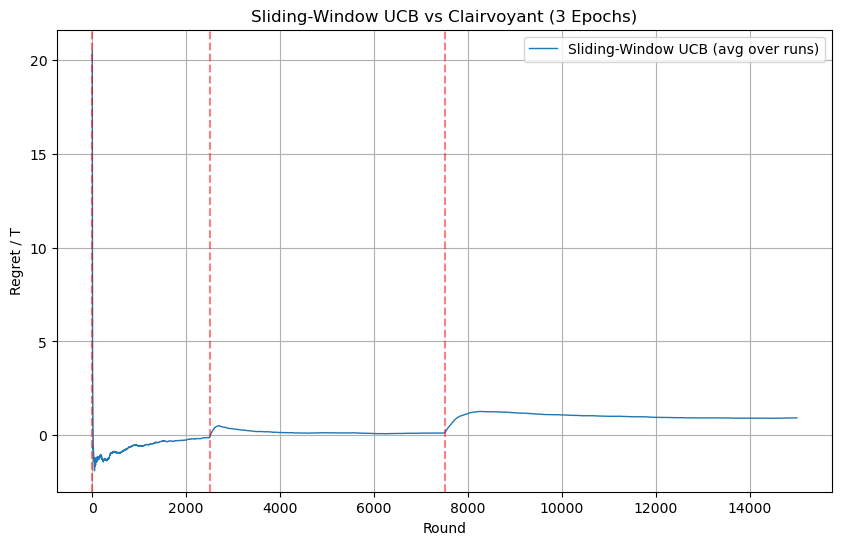

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


# Example conversion functions
def conv_fn_1(price_idx):
    return 0.1 * (price_idx + 1)

def conv_fn_2(price_idx):
    return 0.5 - 0.1 * price_idx

def conv_fn_3(price_idx):
    return 0.2 + 0.05 * price_idx


# Example mu matrices
mu1 = np.array([[1, 2, 3],
                [2, 4, 6]])
mu2 = np.array([[3, 2, 1],
                [6, 4, 2]])
mu3 = np.array([[2, 3, 4],
                [3, 6, 9]])


# Define intervals (3 epochs in this case)
l = 5000

intervals = [
    {'start': 0, 'end': l*0.5, 'mu': mu1, 'conversion_fn': conv_fn_1},
    {'start': l*0.5, 'end': l*1.5, 'mu': mu2, 'conversion_fn': conv_fn_2},
    {'start': l*1.5, 'end': l*3, 'mu': mu3, 'conversion_fn': conv_fn_3}
]


# Simulation parameters
N, P = intervals[0]['mu'].shape
T_total = l*3
window_size = round(0.35 * l)
n_customers = 10
n_runs = 8  # multiple runs to smooth stochasticity
checkpoint_interval = 1000  # print checkpoint every 1000 rounds
B = round(T_total * n_customers * N * 0.25)


# Run simulations
all_regret_ratios = []
final_regret_ratios = []

env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
agent = CombinatorialUCB(N=2, P=3, B=B, T=T_total, window_size=window_size)

clairvoyant_solutions = []

rho_clar = B / T_total

for interval in intervals:
    mu = np.array(interval['mu'])
    conversion_fn = interval['conversion_fn']

    # f: expected reward per product/price
    f = mu * np.array([conversion_fn(p) for p in range(P)]) * n_customers

    # c: expected cost per product/price
    c = np.array([[conversion_fn(p) for p in range(P)] for _ in range(N)]) * n_customers

    gamma_clar = agent.compute_opt(f, c, rho_clar)

    clairvoyant_solutions.append({
        "start": interval['start'],
        "end": interval['end'],
        "f": f,
        "c": c,
        "rho": rho_clar,
        "gamma": gamma_clar
    })


for seed in range(n_runs):
    np.random.seed(seed)
    
    env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
    agent = CombinatorialUCB(N=2, P=3, B=B, T=T_total, window_size=window_size)
    agent.reset()  # ensure sliding windows are empty
    
    cumulative_regret = 0
    regret_ratio_per_round = []

    for t in range(env.T):
        price_vector = agent.pull_arm()
        demand, profit = env.round(price_vector)
        total_reward = profit.sum()

        # Update agent
        agent.update(price_vector, demand, profit)

        # Clairvoyant sample its action (via LP solution)
        interval_idx = env.current_interval
        clair_info = clairvoyant_solutions[interval_idx]
        gamma = clair_info["gamma"]
        f = clair_info["f"]

        # Sample clairvoyant action + reward for this round
        clair_action, clair_reward_per_round = clairvoyant_sample_action(gamma, f)

        # Update cumulative regret
        cumulative_regret += clair_reward_per_round - total_reward
        regret_ratio_per_round.append(cumulative_regret / (t + 1))

        # Print checkpoint
        if t % checkpoint_interval == 0:
            print(f"Round {t}: Interval {interval_idx}")
            print(f"  Agent prices: {price_vector}, Reward: {total_reward:.2f}")
            print(f"  Clairvoyant prices: {clair_action}, Reward: {clair_reward_per_round:.2f}")
            print(f"  Cumulative regret / t: {cumulative_regret / (t + 1):.3f}\n")

    all_regret_ratios.append(regret_ratio_per_round)
    
    # Save final regret ratio for this run
    final_ratio = regret_ratio_per_round[-1]
    final_regret_ratios.append(final_ratio)
    print(f"Run {seed+1}/{n_runs} finished. Final regret ratio: {final_ratio:.4f}")


avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
avg_final_regret_ratio = np.mean(final_regret_ratios)

# Summary print
print("\n=======================")
print("Summary of final regret ratios:")
for i, val in enumerate(final_regret_ratios, 1):
    print(f"  Run {i}: Final regret ratio = {val:.4f}")
print(f"  Average final regret ratio across runs = {avg_final_regret_ratio:.4f}")
print("=======================\n")



plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_regret_ratio, lw=1, label="Sliding-Window UCB (avg over runs)")

for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)

plt.xlabel("Round")
plt.ylabel("Regret / T")
plt.title("Sliding-Window UCB vs Clairvoyant (3 Epochs)")
plt.grid(True)
plt.legend()
plt.show()

